In [4]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [8]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100,
 'https://ourplnt.com/wp-content/uploads/2020/12/grizzly-bear.jpg?is-pending-load=1')

In [ ]:
download_url(urls[0],'bear_images/bear.jpg')
im = Image.open('bear_images/bear.jpg')
im.thumbnail((256,256))
im

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [11]:
if not path.exists():
    path.mkdir()
if path.exists():
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', max_images=100)
#         print(results)
        download_images(dest, urls=results, max_pics=100)

In [12]:
fns = get_image_files(path)
fns

(#380) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000036.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000093.jpg'),Path('bears/grizzly/00000090.jpg'),Path('bears/grizzly/00000035.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#2) [Path('bears/teddy/00000034.png'),Path('bears/teddy/00000057.jpg')]

In [14]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = bears.dataloaders(path)

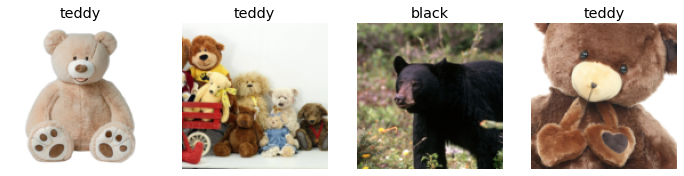

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

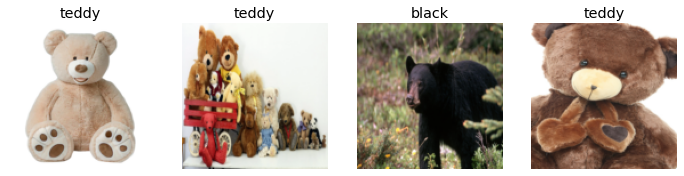

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

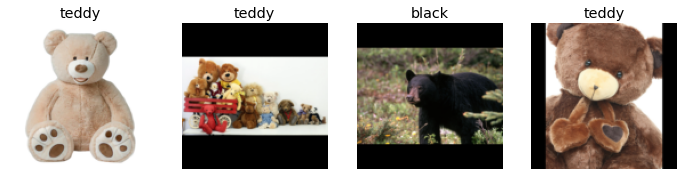

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

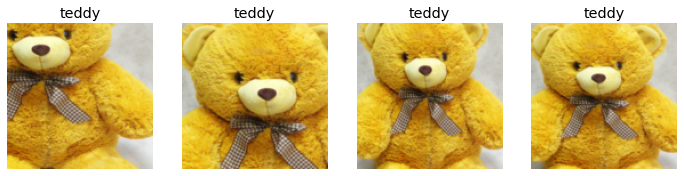

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

Could not do one pass in your dataloader, there is something wrong in it


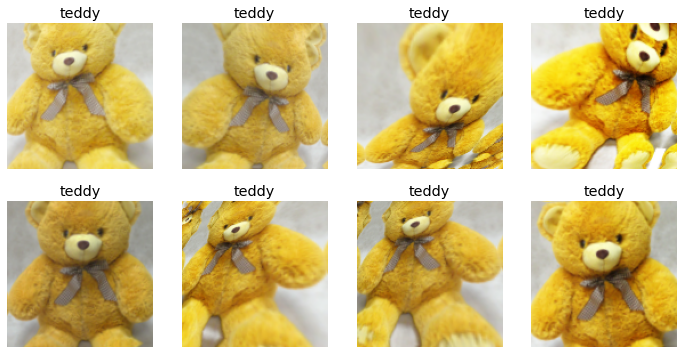

In [21]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [22]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.327211,1.066349,0.320000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.204195,0.270984,0.133333,00:16
1,0.148080,0.022645,0.013333,00:15
2,0.109579,0.008318,0.000000,00:15
3,0.097362,0.007630,0.000000,00:17


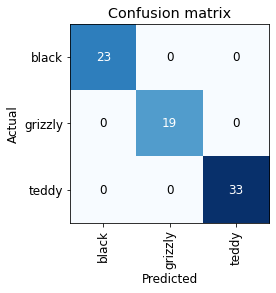

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

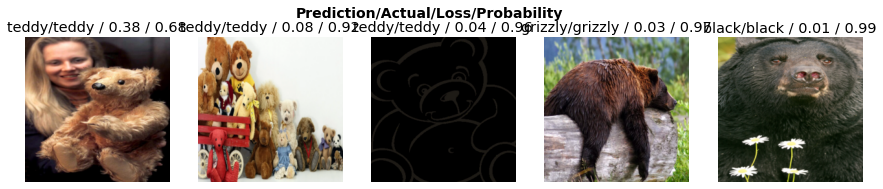

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('bear_images/bear.jpg')

('grizzly', TensorBase(1), TensorBase([1.2982e-05, 9.9999e-01, 6.9827e-08]))

In [31]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [45]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [33]:
img = PILImage.create(btn_upload.data[-1])

In [34]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [35]:
pred,pred_idx,probs = learn_inf.predict(img)

In [36]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9971')

In [37]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [39]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [40]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [41]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 557 kB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 395 kB 29.3 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 29.1 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 14.4 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.0 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.0 OK


### Deploying your app

In [42]:
!pip freeze > requirements.txt